# TME 5.2 : Convolutional Neural Network


## Recherche de pattern (motifs) en utilisant les modèles d'apprentissage profond

Nous allons utiliser l'algorithme Deep Learning Convolutional Neural Network pour la recherche de motifs. 
Notre objectif est de construire un classifieur capable de prédire si une séquence particulière contient le motif d'intérêt.

## 1. Préparation de données

1.1 Comme dans le TME précédent nous allons d'abord générer des données artificielles, un jeu de données de séquences ayant le motif (positives = label 1) et un jeu de données de séquences aléatoires (négatives = label 0). Pour générer les séquences positives, utilisez la matrice de fréquence du motif d'intérêt, par exemple, Atf1 ci-dessous.Nous allons générer 1000 séquences positives et 1000 séquences négatives. 

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

motif_length = 8
num_sample = 1000

nuc = ['A', 'C', 'G', 'T']

MotifConsensus = "TTTGCTCA"

#>AFT1 à remplacer par la matrice du motif d'interet
freq = np.array([
    [108.00,89.00,0.00,115.00,0.00,0.00,0.00,958.00],
    [0.00,0.00,0.00,0.00,1714.00,0.00,1714.00,0.00],
    [0.00,219.00,0.00,1599.00,0.00,0.00,0.00,655.00],
    [1632.00,1451.00,1714.00,0.00,0.00,1714.00,0.00,113.00]
])

def randnuc(p) :
    return np.random.choice(nuc, p)

def generatePWM(MF) :
    t = len(MF)
    n = len(MF[0])
    
    PWM = np.zeros((t,n))
    for i in range(n) :
        s = 0
        for j in range (t) :
            s += MF[j][i]
        for j in range (t) :
            PWM[j][i] = MF[j][i] / s
    return PWM
    
#Transformer freq en matrice de poids position
PWM = generatePWM(freq)
print(PWM)

PWMfreq = np.transpose(PWM)
print(PWMfreq)

motif_length = 8 # à remplacer par taille de la matrice du motif d'interet
num_sample = 1000

[[0.06206897 0.05059693 0.         0.06709452 0.         0.
  0.         0.55504056]
 [0.         0.         0.         0.         1.         0.
  1.         0.        ]
 [0.         0.12450256 0.         0.93290548 0.         0.
  0.         0.37949015]
 [0.93793103 0.82490051 1.         0.         0.         1.
  0.         0.06546929]]
[[0.06206897 0.         0.         0.93793103]
 [0.05059693 0.         0.12450256 0.82490051]
 [0.         0.         0.         1.        ]
 [0.06709452 0.         0.93290548 0.        ]
 [0.         1.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         1.         0.         0.        ]
 [0.55504056 0.         0.37949015 0.06546929]]


In [2]:
def createArtSequences(freq, num_sample=100, motif_length = 7):
    """
    Genere deux jeux de sequences: positives (ayant le motif) et negatives (aleatoires)
    entrée PWM : matrice de poids position qui represent le motif d'interet
    entrée num_sample : int, nombre d'echantillons
    sortie pos : list contenant les sequences positives
    sortie neg : list contenant les sequences negatives
    """
    pos = []
    neg = []

    PWM = generatePWM(freq)
    PWMfreq = np.transpose(PWM)
    
    s = []
    for i in range (num_sample) :
        for j in range (motif_length) :
            s += random.choice(nuc)
        neg.append("".join(s))
        s = []
        
    for i in range (num_sample) :
        for j in range (motif_length) :
            s += np.random.choice(nuc, 1, p = PWMfreq[j]).tolist()
        pos.append("".join(s))
        s = []    
    
            
    return pos, neg

pos, neg  = createArtSequences(freq, num_sample, motif_length)
[''.join(x) for x in pos[1:10:]]
[''.join(x) for x in neg[1:10:]]


#genere y dans le format attendu numpy array (num_sample*2, 2)
#premiere colonne correspond à la prob d'etre positive et deuxiemme d'etre negative
s = (num_sample, 2)
y = np.concatenate((np.zeros(s), np.zeros(s)))
count = 0
for i in range(len(y)):
  if count < num_sample:
    y[i,0] = 1
  else:
    y[i,1] = 1
  count+=1

print(y.shape)
input_labels = y

print (input_labels[0]) #positive
print (input_labels[-2])#negative

print (input_labels.shape)
sequencesPos =  [''.join(x) for x in pos]
sequencesNeg =  [''.join(x) for x in neg]

sequences = sequencesPos + sequencesNeg
print("\nsequencesPos (", len(sequencesPos), ") :", sequencesPos[0:10], "\nsequencesNeg (", len(sequencesPos), ") :", sequencesNeg[0:20])
print(type(sequences))


(2000, 2)
[1. 0.]
[0. 1.]
(2000, 2)

sequencesPos ( 1000 ) : ['TTTGCTCT', 'TTTGCTCA', 'TTTGCTCA', 'TGTGCTCA', 'TTTGCTCA', 'TATGCTCA', 'TTTGCTCT', 'TTTACTCA', 'ATTGCTCG', 'TTTGCTCG'] 
sequencesNeg ( 1000 ) : ['TTTGATCC', 'TGTCGCCT', 'GTCATAGC', 'TCAACAGC', 'ATAGACAT', 'GATTAAGG', 'GGAATATG', 'TTCCCAGC', 'TTTCTGAA', 'TTACCAGA', 'TCGAGTCA', 'CATCTCCC', 'CGAGTCTC', 'CCCCCATC', 'GATTTCTG', 'GAAGATTC', 'GAGGAGGT', 'TATTGTGT', 'TTGGGACA', 'CACCTGGT']
<class 'list'>


1.2. L'étape suivante consiste à organiser les données dans un format qui peut être transmis à un algorithme d'apprentissage profond. 
La plupart des algorithmes d'apprentissage profond acceptent les données sous forme de vecteurs ou de matrices 
(ou plus généralement de tenseurs).

Pour obtenir chaque séquence d'ADN sous la forme d'une matrice, nous utilisons une codage (One hot encoding), 
qui code chaque base d'une séquence sous la forme d'un vecteur à 4 dimensions, avec une dimension distincte pour chaque base. 
Nous plaçons un "1" dans la dimension correspondant à la base trouvée dans la séquence d'ADN, et des "0" dans tous les autres emplacements. 
Nous concaténant ensuite ces vecteurs à 4 dimensions le long des bases de la séquence pour former une matrice.


Exemple
-----------------------
DNA Sequence #1: CCGA
<br>
One hot encoding de #1:
```
 [[0. 0. 0. 1]
 [1. 1. 0. 0]
 [0. 0. 1. 0]
 [0. 0. 0  0]]
```



Faire une fonction pour encoder les sequences d'ADN en utilisant l'One hot encoding 

In [3]:
def one_hot_encode(seq):
    """
    entrée seq: sequence d'ADN
    sortie oneHot: numpy array (tmotif_length x 4)
    """
    mapping = dict(zip("ACGT", range(4)))    
    seq2 = [mapping[i] for i in seq]
    # print(seq2)
    return np.eye(4)[seq2]

print (one_hot_encode('TTTGCTCA'))
#[[1. 0. 0. 0.]
# [0. 1. 0. 0.]]

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]


Faire une fonction pour générer la matrice que représente les données d'entrée d'un CNNs

In [4]:

def encode_sequences(sequences):
  """
    entrée sequences: list de sequences d'entrainement
    soirtie input_features: numpy array (numSamples x motif_length x 4)
  """

  input_features = []

  for seq in sequences :
    matrix = one_hot_encode(seq)
    input_features.append(matrix)

  #print(input_features)
  return np.stack(input_features)

input_features = encode_sequences(sequences)
print (input_features.shape)

(2000, 8, 4)


1.3. Nous divisons également les données en deux jeux, l'un pour l'entraînement et l'autre pour le test. L'objectif du jeu de test est de pouvoir mesurer la performance du modèle sur de nouvelles données, qui n'ont pas été vues auparavant pendant l'entraînement. Plus tard, nous diviserons à nouveau le jeu d'entraînement pour avoir deux jeux pour avoir aussi des données de validation.

In [5]:
from sklearn.model_selection import train_test_split

print(input_features.shape)
print(input_labels.shape)

train_features, test_features, train_labels, test_labels = train_test_split(input_features, input_labels, test_size=0.25, random_state=42)

# print(train_features[:10])
print(test_labels.shape)

(2000, 8, 4)
(2000, 2)
(500, 2)


## 2. Select the Architecture and Train


![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-31-49.png?raw=true)

2.1 - Nous allons  choisir un simple réseau neuronal convolutionnel 2D (CNN), couramment utilisé dans l'apprentissage profond pour les applications en bioinformatique.

Nous utiliserons la bibliothèque d'apprentissage profond Keras. Il nous suffit de spécifier les types de couches que nous souhaitons inclure dans notre réseau, ainsi que la dimensionnalité de chaque couche. Le CNN que nous générons dans cet exercice se compose des couches suivantes :

 - Conv2D : nous définissons notre couche convolutive comme ayant 32 filtres (nodes) de taille 3x3 (kenel_size).

 - Conv2D : une autre couche convolutive comme ayant 64 filtres (nodes) de taille 3x3 (kenel_size), fonction d'activation="relu".

 - MaxPooling2D : après la convolution, nous utilisons une couche de pooling pour réduire l'échantillonnage des sorties convolutifs. Bien que cela ne soit pas toujours nécessaire, il s'agit d'une forme typique de sous-échantillonnage non linéaire utilisée dans les CNN. Notre pool_size sera 2x2

 - Aplatir (Flatten) : Cette couche aplatit la sortie de la couche precedent.

- Dense : La première couche Dense crée comprime la représentation de la couche aplatie, ce qui donne une couche plus petite avec 16 tenseurs (function d'activation relu, et la deuxième couche Dense fait converger les tenseurs vers la couche de sortie (dense_2) qui se compose des deux valeurs de réponse possibles (0 ou 1).

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential

model2 = Sequential()
# model2.add(Conv2D(filters=32, kernel.size=3, input-shape=(motif_length, 4, 1))
model2.add(Conv2D(filters=32, kernel_size=3, input_shape=(motif_length, 4, 1)))

model2.add(Conv2D(64 , (3, 3), padding="same", activation="relu"))

model2.add(MaxPooling2D(pool_size = (2, 2)))

model2.add(Flatten())
model2.add(Dense(16, activation='relu'))
model2.add(Dense(2, activation='softmax'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 2, 32)          320       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 2, 64)          18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 1, 64)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 16)                3088      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                        

2.2 Nous sommes maintenant prêts à entraîner le réseau CNN. 
Nous allons diviser le jeu de données d'entraînement en jeux de données d'entraînement et un jeu de validation. 
Nous n'effectuerons l'entraînement que sur l'ensemble de d'entraînement réduit, 
mais nous tracerons la courbe d'erreur en utilisant les deux jeux de données de formation et de validation. 
Lorsque la perte de l'ensemble de validation cesse de s'améliorer ou s'aggraver tout au long des cycles d'apprentissage, 
il est temps d'arrêter l'entraînement, car le modèle a déjà convergé.

In [7]:
import matplotlib.pyplot as plt

print (train_features.shape)
print (train_labels.shape)


(1500, 8, 4)
(1500, 2)


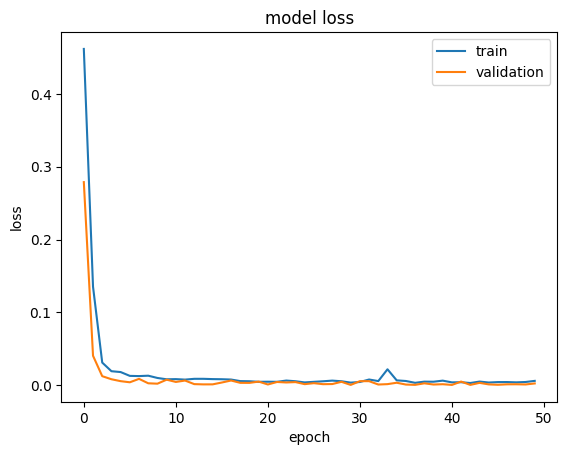

In [8]:

history = model2.fit(train_features, train_labels, epochs=50, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

2.3 De même, nous pouvons représenter la précision de notre réseau CNN pour la tâche de classification binaire. 
La mesure utilisée dans cet exemple est la précision binaire, qui calcule la proportion de prédictions correspondant aux étiquettes 
ou aux variables de réponse. D'autres mesures peuvent être utilisées dans différentes tâches, par exemple, l'erreur quadratique moyenne est généralement utilisée pour mesurer la précision 

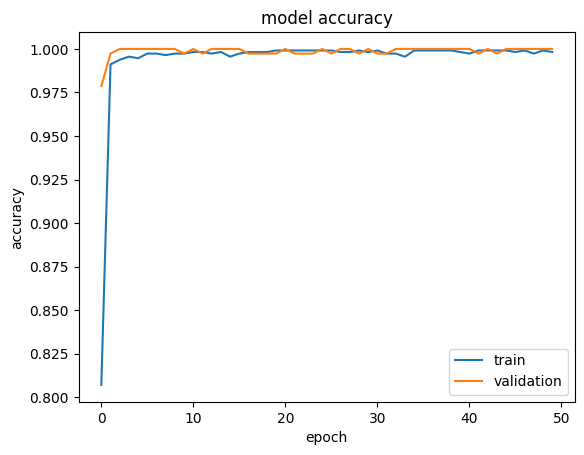

In [9]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

## 3. Evaluation

![alt text](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/Screenshot%20from%202018-08-01%2020-32-12.png?raw=true)

3.1 - La meilleure façon d'évaluer si le réseau a appris à classer les séquences est d'évaluer ses performances sur un nouvel ensemble de test composé de données qu'il n'a pas du tout observées pendant l'entraînement. Nous évaluons ici le modèle sur l'ensemble de test et présentons les résultats sous la forme d'une matrice de confusion. Presque toutes les séquences testées devraient être correctement classées.

16/16 [==============================] - 0s 1ms/step
(500, 2) (500, 2)
Confusion matrix:
 [[256   1]
 [  0 243]]


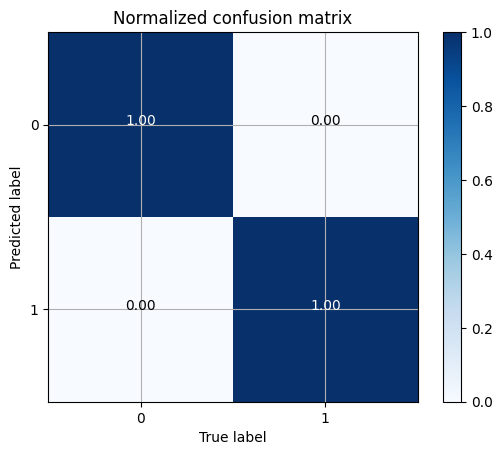

In [10]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model2.predict(np.stack(test_features))
# print(predicted_labels)
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print(test_labels.shape, predicted_labels.shape)
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment='center', color='white' if cm[i, j] > 0.5 else 'black')

## 4. Application sur vos données

Vous pouvez entraîner un réseau CNN pour reconnaître un motif d'intérêt. Par exemple le Mac1 qui figure sur la liste "Tablemotifs-Etudiants.pdf". Pour cela, nous avons téléchargé la matrice de fréquence de Mac1 du site JASÄR https://jaspar.genereg.net/matrix/MA0326.1/
Vous pouvez entraîner un réseau CNN pour reconnaître un motif d'intérêt. Par exemple le Mac1 qui figure sur la liste "Tablemotifs-Etudiants.pdf". Pour cela, nous avons téléchargé la matrice de fréquence de Mac1 du site
Et procéder comme avant pour générer les données d'entraînement, validation et test.Une fois le modèle entraîné vous pouvez le tester sur vous séquences et vérifier combien de fois vous avez trouvé le motif d'intérêt sur vous données. Si le nombre d'occurrence est supérieur au hasard vous avez de forte chance que le motif d'intérêt soit représenté dans vos données. Vous pouvez répéter l'expérience pour plusieurs motifs
 d'intérêt et montrer le(s) quel(s) est(sont) le(s) plus probable.

In [11]:
import numpy as np

motif_length = 8
num_sample = 1000

# # PFM from JASPAR
# motif = np.array([[   0,   2, 104, 104,   1,   2, 103, 102,   0,   0,  99, 105,   0,   0, 100, 102,   5,   3],
#                   [   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   4,   0,   0,   2,   3,   0,   0,   3],
#                   [ 105, 103,   1,   1, 104, 102,   2,   3, 104, 103,   2,   0, 105, 103,   0,   2,  97,  97],
#                   [   0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,   2,   1,   3,   2]])

#matrice de frequence de Mac1 TTTGCTCA
motif = np.array([
    [108.00,89.00,0.00,115.00,0.00,0.00,0.00,958.00],
    [0.00,0.00,0.00,0.00,1714.00,0.00,1714.00,0.00],
    [0.00,219.00,0.00,1599.00,0.00,0.00,0.00,655.00],
    [1632.00,1451.00,1714.00,0.00,0.00,1714.00,0.00,113.00]
])


In [24]:
def readFasta(genome):
    sequence = []
    file = open(genome, "r")
    sequences = []
    seq = ""
    for s in file:
        if s[0] != ">":
            seq += s.strip().upper()
        else:
            sequences.append(seq)
            seq = ""
    return sequences[1:]
genome = "Sequence_by_Peaks_4.fasta"
sequence = readFasta(genome)
print(sequence)

seq = ""
for i in sequence :
  seq += i.strip().upper()

sequences = []
for i in range (len(seq) - motif_length + 1) :
        motif = seq[i : i + motif_length]
        sequences.append(motif)

def reversecompl(seq:str):
    """Renvoie le brin complémentaire d’une séquence.
    entrée seq : sequence de nucléotides (brin sens)
    sortie     : sequence de nucléotides (brin complementaire)
    >>> reversecompl('AACGTGGCA')
    'TGCCACGTT'
    """
    compl = {'A': 'T', 'C': 'G', 'G': 'C', 'T':'A'}
    res = ""
    
    for letter in seq :
        res += compl.get(letter)
    
    return res[::-1]

sequence2 = reversecompl(seq)
for i in range (len(sequence2) - motif_length + 1) :
        motif = sequence2[i : i + motif_length]
        sequences.append(motif)

print(len(sequences))

['GTACCCTGTGTATATGCTTTGGCTGGTGTGTGTCGCGCAAGAGTATTGATGATGCAGTGTTATAATCCCTGAACCTTTGACAGCTCTGGCACCTCTCTGTGTATGTGTGTACACCCCCCTCTAGAGGGGGAGTAACTCGAAATTATTATTCTAACAGATGATCATATGATCATACCGTGCCCACGAATATGAGCGTCTTAAACGACAATGACGCCAGGCATTATACCGCTCATACCGGTGCAGAAGATAGCCTATAAAAGATAAGATAAGATATAGGCCGGTAACCGACTATCATCTTACAGGTGAAAACCAATTGAGTTAGGGCTTCTTAGAACCAGTTTATCCAAAGACTAAAGGTATAAAAGGAGCCCTCATCTCTATTCAGTTAAACCGAAGTTCTAGTATCTTATTCCGTATAATAACAAGAGAACAACCAGTATAGTCTGTATAATACCCTTAGAGTTTCTGAATCGCTCTATCATCATGTCTTCCAATAACTGGACACAAGAACTCACAACTCATCAAGATCGTCTTAGACTATCGCAACACAATGCCCACGTTGGATCACCTACAACGCGATTCTGAGCACATATAACCTCCTCCTCCAATGTAAAAAGACTCATATTCCAGGGACAAATGTATATTAGCTCATTGTATTAGCTTTGTATTAGCTCATGATTGACATGTATATTGGCACAATTTATATTAGCTCATAAAAAATGAGCTAATATAACAGAAGCACCCGAATCCTGGTGCTGCAAAAATCCTTGGTATATAAACGTATGGCTGCAGAGAGTAATACTCTTGTCAGATGCACTATGTAATAACACTTCATATAGCCAACAAGAACTGCTTTTAAGATACAAAGATGAAATTCTTGCTGTTCGCTGCTGTCGCACAGGCCTACTTGCAACTGGACTTCGAACGTCAGACTGCCCAGGACGTCGCCTTGGCCAAGAGACACACCTCCAACGGTGTCGCAAACGCCATGGACGTCC

In [26]:
test_features = encode_sequences(sequences)
print (test_features.shape)

(58146, 8, 4)


In [29]:
predicted_labels = model2.predict(np.stack(test_features))
# print(predicted_labels[:10])
cptmotif = 0
cptnomotif = 0

for i in range(len(predicted_labels)) :
  elmt = predicted_labels[i]
  if elmt[0] >= 0.99 :
    # print(elmt)
    # print(sequences[i])
    cptmotif += 1
  else :
    cptnomotif += 1

print(cptmotif, cptnomotif)

1818/1818 [==============================] - 2s 1ms/step
85 58061
